In [18]:
from IPython.display import Image

**Links**
- [Neo4j Browser Interface](http://localhost:7474/browser/)
- [Cypher Query Language Docs](https://neo4j.com/developer/cypher/)

# 1. Importing MMR dataset in Neo4j
Due to the huge size of the dataset (consisting of both usernames + MMR files), I used the [batch-import tool](https://neo4j.com/docs/operations-manual/current/tools/import/) which helped me to conveniently import the dataset in a `graph.db` Neo4j database. As recommended by the guidelines, I kept the actual data files separate from the headers, since the headers have to provide crucial info to the Neo4j interpreter such that the database is built the proper way.

## 1.1 Data Preparation
The structure of the database consists of **nodes** of type **User** and relationships with label **MENTIONS**, such that a common (undirected) node-to-node relationship would be represented as `(n:User)-[r:MENTIONS]-(m:User)` in Cypher query language.

**Note**: since we're not going to have more than one node type (all nodes are `Users`) and one relationship type (all relationships are `MENTIONS`), when querying in Cypher the types may be omitted and the common node-to-node pattern becomes `(n)-[r]-(m)`.

For this purpose, the `mmr_encoded_header.csv` and the `usernames_header.csv` are shown below:
- **MMR Header**: `:START_ID(User),:END_ID(User)`
- **Usernames Header**: `username,encoding:ID(User)`

It's worth pointing out that the `encoding` property of the `User` node has been intentionally named as such and not `id`, not to create confusion with the internal built-in property `<id>` of Neo4j. Intuitively, each line of the MMR dataset will represent a relationship that should connect nodes based on the property labeled with `ID(User)` defined by the usernames header file.

## 1.2 Network Data Import
After these preparation steps, I was then ready to bulk import the data with the following shell command:
```
neo4j-admin import --id-type INTEGER --nodes:User "path/to/usernames_header.csv,path/to/usernames.csv" --relationships:MENTIONS "path/to/mmr_encoded_header.csv,path/to/mmr_encoded.csv"
```
The tool turned out to be fairly quick and I ended up with a nice full network consisting of:

| Total Relationships | Total Nodes |
|---|---|
| 612.497.446 (~600M) | 89.577.277 (~90M) |

Last but not least, an **index** has been created on the encoding property by adding a unique property constraint. This could potentially speed up information retrieval from the database when using the index.
```
CREATE CONSTRAINT ON (n:User) ASSERT n.encoding IS UNIQUE
```

# 2. Working with Neo4j and Cypher
Neo4j comes handy to quickly query the network and get to see the structure and some examples in the GUI provided by the browser. After playing around a bit with a few example queries, I noticed a downside of the current network structure as defined in the previous sections.

## 2.1 Examples

All Barack Obama's mutual interactions:

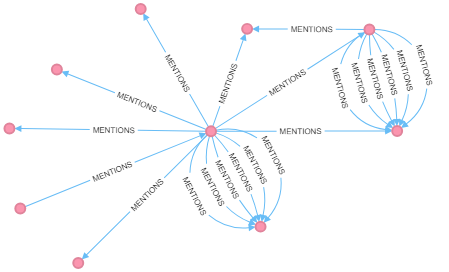

In [17]:
Image(filename="../Pictures/barackobama.png",width=500, height=500)

Hillary Clinton's top mutual interactions:

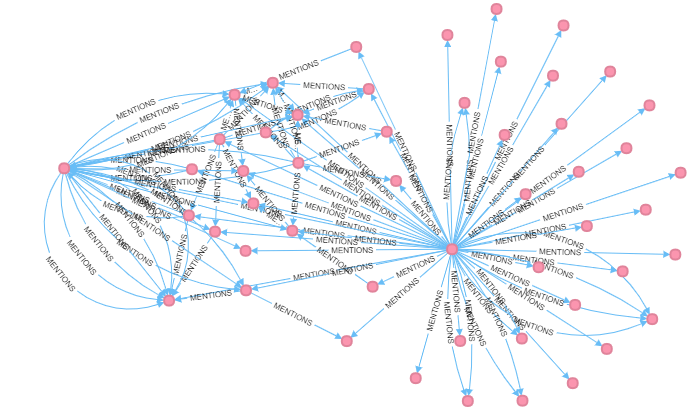

In [12]:
Image(filename="../Pictures/hillaryclinton_top.png",width=500, height=500)

All U.S. President Donald Trump's mutual interactions:

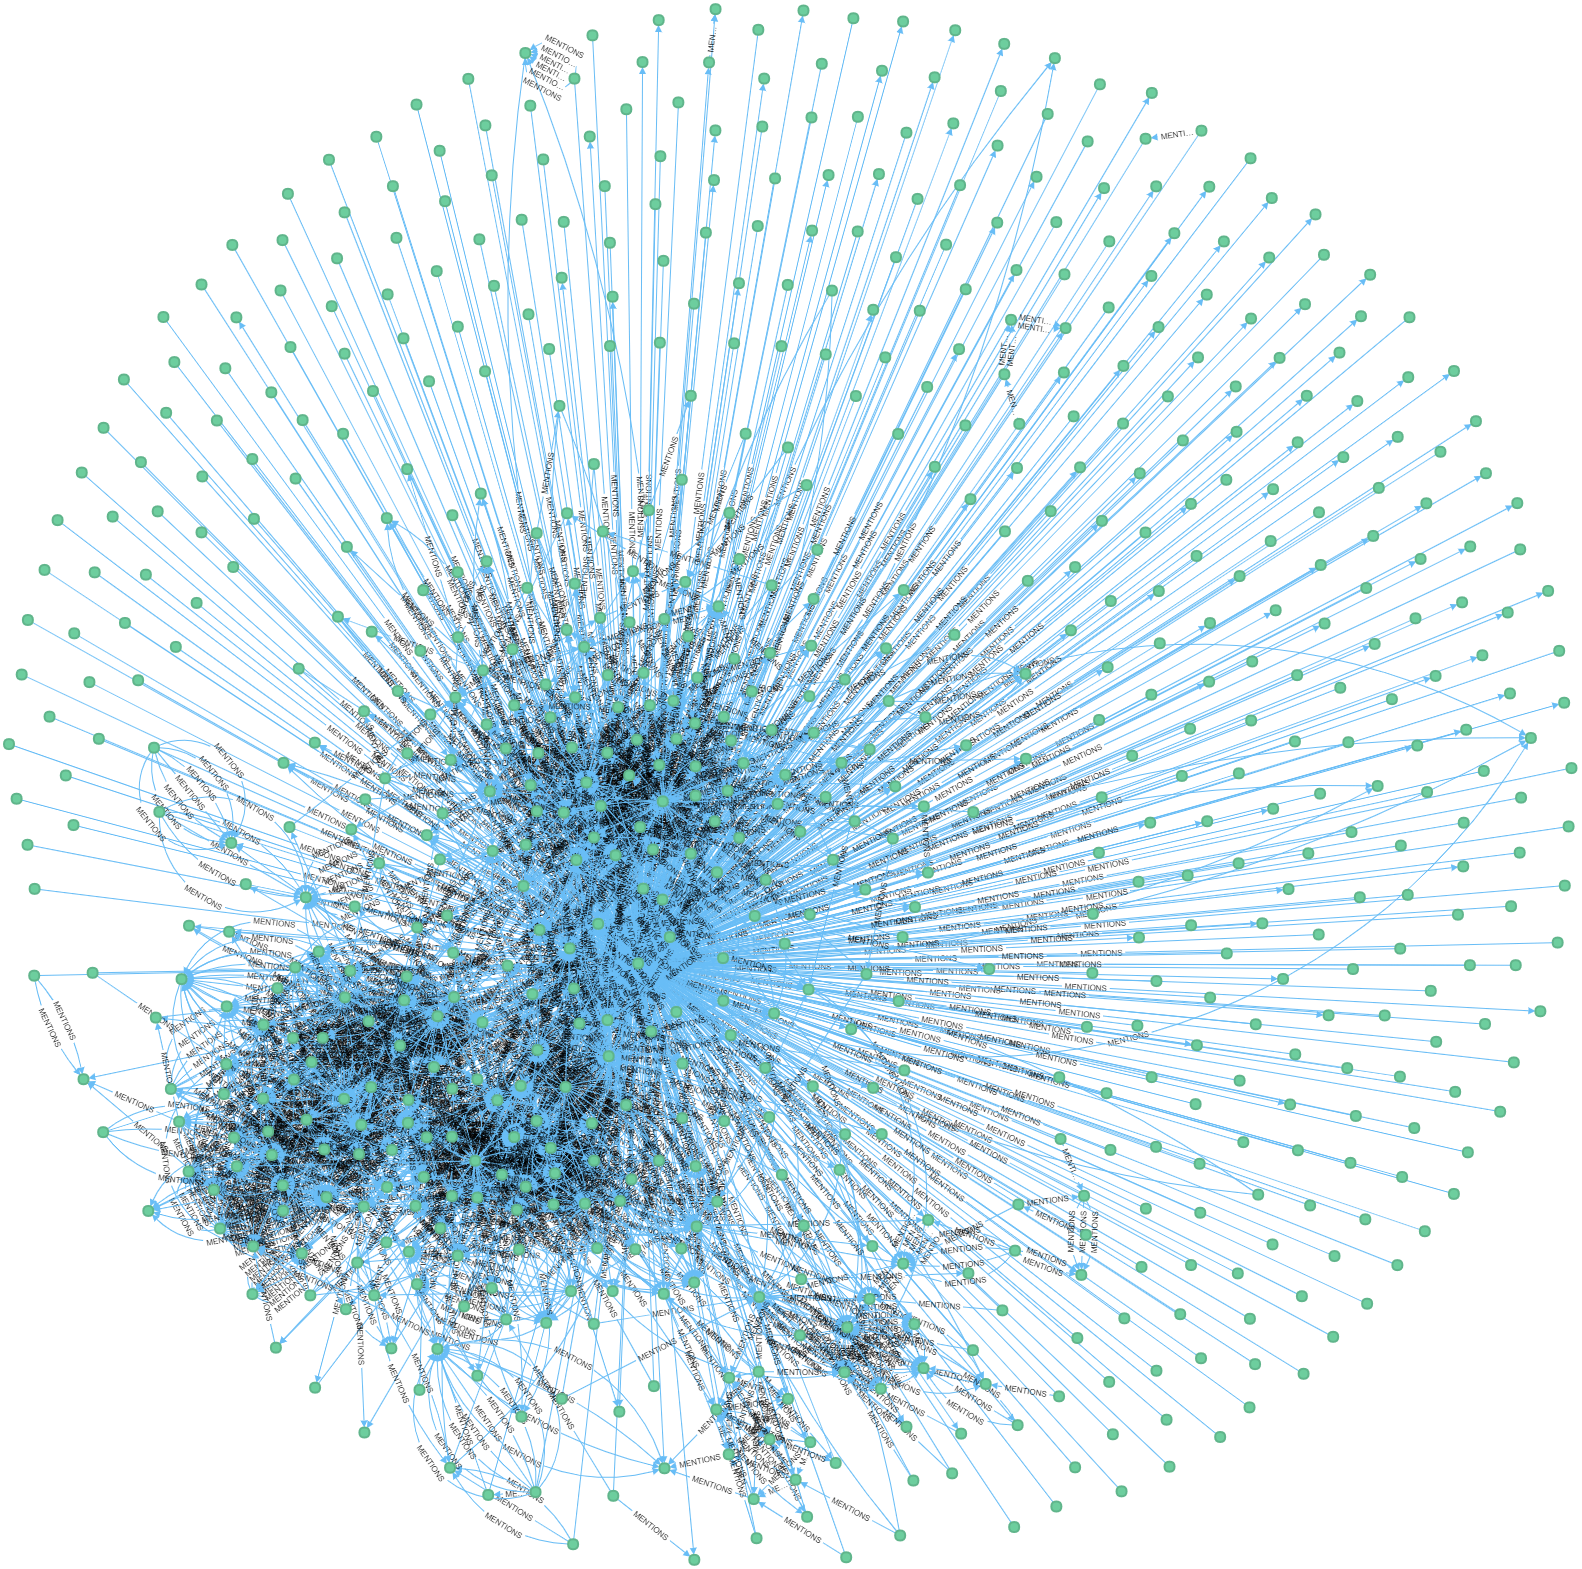

In [10]:
Image(filename="../Pictures/realdonaldtrump_interactions.png",width=500, height=500)

## 2.2 Drawback of the current network structure
As it can be seen from the networks generated by the previous examples, the presence of two specific nodes that have multiple relationships between them is evident: e.g. nodes $n_1$ and $n_2$ may be connected by $k$ multiple distinct relationships of type `MENTIONS` $r_{1...k}$. Since all these $k$ relationship store no actual metadata, showing all of them is redundant or at least not really meaningful at this point. Why is this happening? Obviously, due to the nature of the raw data the graph is originated from, two nodes may be connected with each other up to $t$ times, where $t$ = number of periods meant as 3 months windows from September 2013 to September 2016. In our case, $t = 13$. Therefore, I see the possible solutions to overcome this redundancy:
1. Get rid of duplicate relationships, but this way we would actually lose relevant temporal information, or...
2. **Add metadata to the relationships / edges**, in a way such that a single relationship $r$ between two nodes $n_1$,$n_2$ may store information about what period(s) the two users have been mentioning each other.

With the solution as of the second bullet, we could therefore represent a **static graph with temporal information**. Neo4j allows to store an **array** as a node property, therefore a little bit of refactoring in the CSV files will be enough to achieve this. This improvement could potentially result in less disk space usage and much lower number of relationships. The array of periods could be stored as an array of **Integers** with values ranging from 0 to 12, as long as we encode the text information beforehand.

As a further proof of the concept shown above, I wanted to find out who are the top most mentioned users overtime for impactful users such as U.S. politicians, who probably generated a lot of traffic and therefore are more likely to represent a node in the MMR data. As mentioned before, keep in mind that the number of mutual interactions could be *at most* 13.

Hereby the results for **Donald Trump**. It is not super surprising, however, that his top mutual mentions occurred with members of his family: 3 of his sons are ranked among the top 5 positions. Third place is taken by the famous *Fox & Friends*, the daily morning conservative news/talk program that airs on *Fox News Channel* (ranked at 6th place).

| Twitter Username | Total Mutual Mentions |
|---|---|
| erictrump | 9 |
| ivankatrump | 8 |
| foxandfriends | 8 |
| donaldjtrumpjr | 7 |
| trumpdoral | 6 |
| foxnews | 6 |
| cnn | 6 |
| trumpcollection | 6 |
| greta | 5 |
| megynkelly | 4 |

Here's the case of **Hillary Clinton**. Apparently, Hillary has maintained longer mutual relationships with her Twitter accounts used to promote her campaign across the U.S. in several states (*Hillary For Southern California*, *Hillary For New Hampshire*, *Hillary For America*, *Hillary For Nevada*, and another politician who positively contributed to her campaign, *Lorella Praeli*.

| Twitter Username | Total Mutual Mentions |
|---|---|
| thebriefing2016 | 6
| hillaryforsc | 4
| hillaryfornh | 4
| lorellapraeli | 4
| hfa | 3
| hillaryfornv | 3
| chelseaclinton | 3
| hillaryforia | 3
| gabbygiffords | 2
| joebiden | 2

## 2.3 Second iteration: adding relationships metadata

First, I edited the `mmr_encoded_header.csv` by adding an additional column heading to store the encoded periods:
```
:START_ID(User),:END_ID(User),periods:integer[]
```
In order to transform the dataset, I require another big iteration over the 9.7GB file which could potentially be extremely slow. I can try to optimize performance by using **Julia** over Python instead.

## Possible optimizations
- I could remove the username string from the nodes to save space, but let's experiment with the performance before.